# Assignment 2. Language modeling.

This task is devoted to language modeling. Its goal is to write in PyTorch an RNN-based language model. Since word-based language modeling requires long training and is memory-consuming due to large vocabulary, we start with character-based language modeling. We are going to train the model to generate words as sequence of characters. During training we teach it to predict characters of the words in the training set.



## Task 1. Character-based language modeling: data preparation (15 points).

We train the language models on the materials of **Sigmorphon 2018 Shared Task**. First, download the Russian datasets.

In [1]:
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-train-high
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-dev
!wget https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-test

--2020-03-28 13:25:25--  https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-train-high
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 151.101.244.133
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|151.101.244.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 533309 (521K) [text/plain]
Сохранение в: «russian-train-high»

russian-train-high  100%[===================>] 520,81K  1,63MB/s    за 0,3s    

2020-03-28 13:25:26 (1,63 MB/s) - «russian-train-high» сохранён [533309/533309]

--2020-03-28 13:25:27--  https://raw.githubusercontent.com/sigmorphon/conll2018/master/task1/surprise/russian-dev
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 151.101.244.133
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|151.101.244.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 53671 (52K) [text/plain]
Сохране

**1.1 (1 points)**
All the files contain tab-separated triples ```<lemma>-<form>-<tags>```, where ```<form>``` may contain spaces (*будете соответствовать*). Write a function that loads a list of all word forms, that do not contain spaces.  

In [2]:
def read_infile(infile):
    with open(infile, 'r') as fd:
        text = list(map(lambda x: x.split('\t'), fd.readlines()))
    return [x[1].lower() for x in filter(lambda x: ' ' not in x[1], text)]

In [3]:
train_words = read_infile("russian-train-high")
dev_words = read_infile("russian-dev")
test_words = read_infile("russian-test")
print(len(train_words), len(dev_words), len(test_words))
print(*train_words[:10])

9213 917 922
валлонскому незаконченным истрёпывав личного серьгам необоснованным тюти заросла идеальна гулкой


**1.2 (2 points)** Write a **Vocabulary** class that allows to transform symbols into their indexes. The class should have the method ```__call__``` that applies this transformation to sequences of symbols and batches of sequences as well. You can also use [SimpleVocabulary](https://github.com/deepmipt/DeepPavlov/blob/c10b079b972493220c82a643d47d718d5358c7f4/deeppavlov/core/data/simple_vocab.py#L31) from DeepPavlov. Fit an instance of this class on the training data.

In [4]:
from deeppavlov.core.data.simple_vocab import SimpleVocabulary

vocab = SimpleVocabulary(special_tokens=["BEGIN", "END", "PAD"], save_path='.')
vocab.fit([list(x[5:-3]) for x in train_words])
print(len(vocab))

2020-03-28 13:25:31.140 WARNING in 'deeppavlov.core.models.serializable'['serializable'] at line 49: No load path is set for SimpleVocabulary in 'infer' mode. Using save path instead


37


**1.3 (2 points)** Write a **Dataset** class, which should be inherited from ```torch.utils.data.Dataset```. It should take a list of words and the ```vocab``` as initialization arguments.

In [5]:
import torch
from torch.utils.data import Dataset as TorchDataset

class Dataset(TorchDataset):
    
    """Custom data.Dataset compatible with data.DataLoader."""
    def __init__(self, data, vocab):
        self.data = data
        self.vocab = vocab

    def __getitem__(self, idx):
        """
        Returns one tensor pair (source and target). The source tensor corresponds to the input word,
        with "BEGIN" and "END" symbols attached. The target tensor should contain the answers
        for the language model that obtain these word as input.        
        """
        return (torch.tensor(list(map(self.vocab, ['BEGIN', *[letter for letter in self.data[idx]]]))),
                torch.tensor(list(map(self.vocab, [*[letter for letter in self.data[idx]], 'END']))))
    
    def __len__(self):
        return len(self.data)

In [6]:
train_dataset = Dataset(train_words, vocab)
dev_dataset = Dataset(dev_words, vocab)
test_dataset = Dataset(test_words, vocab)

**1.4 (3 points)** Use a standard ```torch.utils.data.DataLoader``` to obtain an iterable over batches. Print the shape of first 10 input batches with ```batch_size=1```.

In [7]:
from torch.utils.data import DataLoader

dataset = DataLoader(train_dataset, batch_size=1)
for idx, (x, y) in enumerate(dataset):
    if idx == 10:
        break
    print(x.shape, y.shape, x, y, sep='\n')
    print()

torch.Size([1, 12])
torch.Size([1, 12])
tensor([[ 0,  9,  5, 11, 11,  7,  3, 10, 14,  7, 18, 17]])
tensor([[ 9,  5, 11, 11,  7,  3, 10, 14,  7, 18, 17,  1]])

torch.Size([1, 14])
torch.Size([1, 14])
tensor([[ 0,  3,  6, 19,  5, 14,  7,  3, 13,  6,  3,  3, 22, 18]])
tensor([[ 3,  6, 19,  5, 14,  7,  3, 13,  6,  3,  3, 22, 18,  1]])

torch.Size([1, 11])
torch.Size([1, 11])
tensor([[ 0,  4, 10,  8, 12, 28, 25, 22,  9,  5,  9]])
tensor([[ 4, 10,  8, 12, 28, 25, 22,  9,  5,  9,  1]])

torch.Size([1, 8])
torch.Size([1, 8])
tensor([[ 0, 11,  4, 13,  3,  7, 23,  7]])
tensor([[11,  4, 13,  3,  7, 23,  7,  1]])

torch.Size([1, 8])
torch.Size([1, 8])
tensor([[ 0, 10,  6, 12, 15, 23,  5, 18]])
tensor([[10,  6, 12, 15, 23,  5, 18,  1]])

torch.Size([1, 15])
torch.Size([1, 15])
tensor([[ 0,  3,  6,  7, 26,  7, 10,  3,  7,  9,  5,  3,  3, 22, 18]])
tensor([[ 3,  6,  7, 26,  7, 10,  3,  7,  9,  5,  3,  3, 22, 18,  1]])

torch.Size([1, 5])
torch.Size([1, 5])
tensor([[ 0,  8, 27,  8,  4]])
tensor([[ 8, 

**(1.5) 1 point** Explain, why this does not work with larger batch size.

Все элементы тензора должны иметь одинаковую размерность, а в нашем примере размерность зависит от размера слова, которая может различаться у элементов внутри тензора при batch_size > 1.

**(1.6) 5 points** Write a function **collate** that allows you to deal with batches of greater size. See [discussion](https://discuss.pytorch.org/t/dataloader-for-various-length-of-data/6418/8) for an example. Implement your function as a class ```__call__``` method to make it more flexible.

In [8]:
def pad_tensor(vec, length, dim, pad_symbol=2):
    """
    Pads a vector ``vec`` up to length ``length`` along axis ``dim`` with pad symbol ``pad_symbol``.
    """
    pad_size = list(vec.shape)
    pad_size[dim] = length - vec.shape[dim]
    return torch.cat([vec, torch.ones(*pad_size, dtype=torch.long) * pad_symbol], dim=dim)

class Padder:
    
    def __init__(self, dim=0, pad_symbol=2, max_len=None):
        self.dim = dim
        self.pad_symbol = pad_symbol
        self.max_len = max_len
        
    def __call__(self, batch):
        if self.max_len is None:
            max_len = max([x.shape[self.dim] for x, y in batch])
        else:
            max_len = self.max_len
        batch = list(map(lambda x: \
                (pad_tensor(x[0], length=max_len, dim=self.dim, pad_symbol=self.pad_symbol), 
                 pad_tensor(x[1], length=max_len, dim=self.dim, pad_symbol=self.pad_symbol)), batch))
        xs = torch.stack(tuple(map(lambda x: x[0], batch)))
        ys = torch.stack(tuple(map(lambda x: x[1], batch)))
        return (xs, ys)

**(1.7) 1 points** Again, use ```torch.utils.data.DataLoader``` to obtain an iterable over batches. Print the shape of first 10 input batches with the batch size you like.

In [9]:
from torch.utils.data import DataLoader

dataset = DataLoader(train_dataset, batch_size=2, collate_fn=Padder(dim=0))
for idx, (x, y) in enumerate(dataset):
    if idx == 10:
        break
    print(x.shape, y.shape, x, y, sep='\n')
    print()

torch.Size([2, 14])
torch.Size([2, 14])
tensor([[ 0,  9,  5, 11, 11,  7,  3, 10, 14,  7, 18, 17,  2,  2],
        [ 0,  3,  6, 19,  5, 14,  7,  3, 13,  6,  3,  3, 22, 18]])
tensor([[ 9,  5, 11, 11,  7,  3, 10, 14,  7, 18, 17,  1,  2,  2],
        [ 3,  6, 19,  5, 14,  7,  3, 13,  6,  3,  3, 22, 18,  1]])

torch.Size([2, 11])
torch.Size([2, 11])
tensor([[ 0,  4, 10,  8, 12, 28, 25, 22,  9,  5,  9],
        [ 0, 11,  4, 13,  3,  7, 23,  7,  2,  2,  2]])
tensor([[ 4, 10,  8, 12, 28, 25, 22,  9,  5,  9,  1],
        [11,  4, 13,  3,  7, 23,  7,  1,  2,  2,  2]])

torch.Size([2, 15])
torch.Size([2, 15])
tensor([[ 0, 10,  6, 12, 15, 23,  5, 18,  2,  2,  2,  2,  2,  2,  2],
        [ 0,  3,  6,  7, 26,  7, 10,  3,  7,  9,  5,  3,  3, 22, 18]])
tensor([[10,  6, 12, 15, 23,  5, 18,  1,  2,  2,  2,  2,  2,  2,  2],
        [ 3,  6,  7, 26,  7, 10,  3,  7,  9,  5,  3,  3, 22, 18,  1]])

torch.Size([2, 8])
torch.Size([2, 8])
tensor([[ 0,  8, 27,  8,  4,  2,  2,  2],
        [ 0, 19,  5, 12,  7, 10

## Task 2. Character-based language modeling. (35 points)

**2.1 (5 points)** Write a network that performs language modeling. It should include three layers:
1. **Embedding** layer that transforms input symbols into vectors.
2. An **RNN** layer that outputs a sequence of hidden states (you may use https://pytorch.org/docs/stable/nn.html#gru).
3. A **Linear** layer with ``softmax`` activation that produces the output distribution for each symbol.

In [10]:
import torch.nn as nn

class RNNLM(nn.Module):

    def __init__(self, vocab_size, embeddings_dim, hidden_size, pad_symbol_id=2):
        super(RNNLM, self).__init__()
        self.hidden_size = hidden_size
        self.embeddings_dim = embeddings_dim
        self.pad_symbol_id = pad_symbol_id
        self.vocab_size = vocab_size
        
        self.emb = nn.Embedding(vocab_size, embeddings_dim)
        self.rnn = nn.GRU(embeddings_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        nn.init.kaiming_normal_(self.fc.weight)

        
    def forward(self, inputs, hidden=None):
        if hidden is None:
            hidden = self.init_hidden(inputs.shape)
        out = self.emb(inputs)
        out, h = self.rnn(out, hidden)
        out = self.fc(out)
        
        # calculate loss without paddings
        mask = (inputs == self.pad_symbol_id)
        out[mask] = torch.zeros(self.vocab_size)
        out[mask][:, self.pad_symbol_id] = 1
        
        return (out, h)
    
    def init_hidden(self, inputs_shape):
        return torch.zeros(1, inputs_shape[0], self.embeddings_dim)

**2.2 (1 points)** Write a function ``validate_on_batch`` that takes as input a model, a batch of inputs and a batch of outputs, and the loss criterion, and outputs the loss tensor for the whole batch. This loss should not be normalized.

In [11]:
device = 'cpu'

def validate_on_batch(model, criterion, x, y):
    x = x.to(device=device)
    y = y.to(device=device)
    pred, _ = model(x)
    return criterion(pred.reshape(pred.shape[0] * pred.shape[1], -1), 
                     y.reshape(pred.shape[1] * pred.shape[0]))

**2.3 (1 points)** Write a function ``train_on_batch`` that accepts all the arguments of ``validate_on_batch`` and also an optimizer, calculates loss and makes a single step of gradient optimization. This function should call ``validate_on_batch`` inside.

In [12]:
def train_on_batch(model, criterion, x, y, optimizer):
    model.train()
    optimizer.zero_grad()
    loss = validate_on_batch(model, criterion, x, y)
    loss.backward()
    optimizer.step()
    return np.mean(loss.item())

**2.4 (3 points)** Write a training loop. You should define your ``RNNLM`` model, the criterion, the optimizer and the hyperparameters (number of epochs and batch size). Then train the model for a required number of epochs. On each epoch evaluate the average training loss and the average loss on the validation set. 

**2.5 (3 points)** Do not forget to average your loss over only non-padding symbols, otherwise it will be too optimistic.

### 2.5 implemented inside forward function!

In [13]:
from matplotlib import pyplot as plt
import numpy as np

def plot_loss(train_loss, val_loss, interval=10):
    train = [np.mean(train_loss[i * interval : (i + 1) * interval], axis=0) \
                for i in range((len(train_loss) - interval) // interval)]
    val = [np.mean(val_loss[i * interval : (i + 1) * interval], axis=0) \
                for i in range((len(val_loss) - interval) // interval)]
    plt.plot([a[0] for a in train], [a[1] for a in train], label='train')
    plt.plot([a[0] for a in val], [a[1] for a in val], label='val')
    plt.legend()

In [14]:
from torch import optim

num_epochs=31
lr = 1e-1
model = RNNLM(len(vocab), 30, 30)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train_dataloader = DataLoader(train_dataset, batch_size=5, collate_fn=Padder(dim=0, pad_symbol=vocab("PAD")))
val_dataloader = DataLoader(dev_dataset, batch_size=5, collate_fn=Padder(dim=0, pad_symbol=vocab("PAD")))

In [15]:
train_loss = []
val_loss = []

for e in range(num_epochs):
    for idx, (x, y) in enumerate(train_dataloader):
        train_loss.append((idx + e * len(train_dataloader), train_on_batch(model, loss, x, y, optimizer)))
    for idx, (x, y) in enumerate(val_dataloader):
        model.eval()
        val_loss.append((idx * 10.016304347826088 + e * len(train_dataloader), 
                         validate_on_batch(model, loss, x, y)))

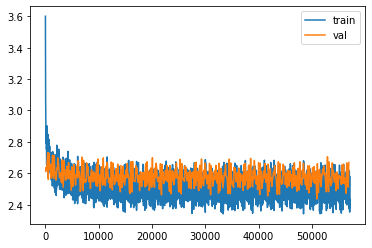

In [16]:
plot_loss(train_loss, val_loss)

**2.6 (5 points)** Write a function **predict_on_batch** that outputs letter probabilities of all words in the batch.

In [17]:
def predict_on_batch(model, batch, hidden=None, dim=-1):
    model.eval()
    batch = batch.to(device=device)
    preds, hidden = model(batch, hidden)
    sm = nn.Softmax(dim=dim)
    return (sm(preds), hidden)

**2.7 (1 points)** Calculate the letter probabilities for all words in the test dataset. Print them for 20 last words. Do not forget to disable shuffling in the ``DataLoader``.

In [18]:
max_len = max(map(lambda x: x[0].shape[-1], test_dataset))

In [19]:
test_dataset_loader = DataLoader(test_dataset, shuffle=False, batch_size=5, 
                                 collate_fn=Padder(dim=0, max_len = max_len, pad_symbol=vocab("END")))

In [20]:
test_probabilities = None
hidden = None

for idx, (x, y) in enumerate(test_dataset_loader):
    if idx == 0:
        test_probabilities, hidden = predict_on_batch(model, x)
    else:
        hidden = hidden[:, :x.shape[0], :]
        preds, hidden = predict_on_batch(model, x, hidden=hidden)
        test_probabilities = torch.cat((test_probabilities, preds))

Не вижу смысла выводить тензор размера (20, max_len, len(vocab)) - ничего не будет видно

Лучше выведу вероятности для слова "мама":

In [21]:
starting_state = torch.tensor([vocab("Begin")])[None, :]
m_state = torch.tensor([vocab("м")])[None, :]
a_state = torch.tensor([vocab("а")])[None, :]
hidden = None

preds, hidden = predict_on_batch(model, starting_state, hidden)
print("P(м) {}".format(preds[0, 0, vocab("м")]))

preds, hidden = predict_on_batch(model, m_state, hidden)
print("P(а) {}".format(preds[0, 0, vocab("а")]))

preds, hidden = predict_on_batch(model, a_state, hidden)
print("P(м) {}".format(preds[0, 0, vocab("м")]))

preds, hidden = predict_on_batch(model, m_state, hidden)
print("P(а) {}".format(preds[0, 0, vocab("а")]))

preds, hidden = predict_on_batch(model, a_state, hidden)
print("P(END) {}".format(preds[0, 0, vocab("END")]))

P(м) 0.031745024025440216
P(а) 0.20663708448410034
P(м) 0.048230819404125214
P(а) 0.11165577173233032
P(END) 0.018316099420189857


**2.8 (5 points)** Write a function that generates a single word (sequence of indexes) given the model. Do not forget about the hidden state! Be careful about start and end symbol indexes. Use ``torch.multinomial`` for sampling.

In [22]:
def generate(model, max_length=20, start_index=0, end_index=1, pad_index=2):
    model.eval()
    prev_letter = start_index
    word = []
    hidden=None
    
    for i in range(max_length):
        cur_idx = torch.tensor([prev_letter])[None, :]
        preds, hidden = predict_on_batch(model, cur_idx, hidden)
        prev_letter = torch.multinomial(preds.squeeze(), 1)
        if prev_letter in [start_index, end_index, pad_index]:
            return ''.join(word)
        prev_letter = prev_letter.numpy()[0]
        word.append(vocab(prev_letter))
    return ''.join(word)

**2.9 (1 points)** Use ``generate`` to sample 20 pseudowords. Do not forget to transform indexes to letters.

In [23]:
for i in range(20):
    print(generate(model))

зожеми
мерело
захпуравший
изыльтивам
центрись
бегеннский
вымзических
злуд
зистерии
вкураниям
ольтика
повое
негрешенное
прифего
додогам
корлисгивам
обации
коспелями
плыкилсяках
огрущивингедите


**(2.10) 5 points** Write a batched version of the generation function. You should sample the following symbol only for the words that are not finished yet, so apply a boolean mask to trace active words.

In [24]:
def generate_batch(model, batch_size, max_length = 20, start_index=0, end_index=1, pad_index=2):
    cur_state = torch.tensor([start_index for i in range(batch_size)]).reshape(batch_size, 1)
    generated_words = []
    generated = None
    hidden = None
    
    for i in range(max_length):
        preds, hidden = predict_on_batch(model, cur_state, hidden)
        cur_state = torch.multinomial(preds.squeeze(), num_samples=1)
        if i == 0:
            generated = cur_state[None, :]
        else:
            generated = torch.cat((generated, cur_state[None, :]))
    for i in range(batch_size):
        cur_tensor = generated[:, i, 0]
        end_pos = max_length
        for j in range(max_length):
            if cur_tensor[j] in [start_index, end_index, pad_index]:
                end_pos = j
                break
        generated_words.append(''.join([vocab(val.item()) for val in cur_tensor[:end_pos]]))
    return generated_words

In [25]:
generate_batch(model, 20)

['билихов',
 'продретивает',
 'досял',
 'пилиальшем',
 'варзов',
 'восровший',
 'слаками',
 'растровогиала',
 'азнисок',
 'жаркаде',
 'выдиксное',
 'стерсная',
 'выцезимное',
 'вестодиктий',
 'згиа',
 'сужижая',
 'ффурфестона',
 'потертите',
 'притапиями',
 'выкомпуют']

**(2.11) 5 points** Experiment with the type of RNN, number of layers, units and/or dropout to improve the perplexity of the model.

### Let's increase the dimensions of the model and add dropout

In [42]:
class RNNLM(nn.Module):

    def __init__(self, vocab_size, embeddings_dim, hidden_size1, hidden_size2, pad_symbol_id=2):
        super(RNNLM, self).__init__()
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.embeddings_dim = embeddings_dim
        self.pad_symbol_id = pad_symbol_id
        self.vocab_size = vocab_size
        
        self.emb = nn.Embedding(vocab_size, embeddings_dim)
        self.rnn = nn.GRU(embeddings_dim, hidden_size1, batch_first=True)
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(hidden_size1, hidden_size2)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size2, vocab_size)
        
    def forward(self, inputs, hidden=None):
        if hidden is None:
            hidden = self.init_hidden(inputs.shape)
        out = self.emb(inputs)
        out, h = self.rnn(out, hidden)
        out = self.dropout1(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout2(out)
        out = self.fc2(out)
        
        # calculate loss without paddings
        mask = (inputs == self.pad_symbol_id)
        out[mask] = torch.zeros(self.vocab_size)
        out[mask][:, self.pad_symbol_id] = 1
        
        return (out, h)
    
    def init_hidden(self, inputs_shape):
        return torch.zeros(1, inputs_shape[0], self.embeddings_dim)

In [44]:
num_epochs=50
lr = 1e-3
model = RNNLM(len(vocab), 30, 30, 50)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr)
train_dataloader = DataLoader(train_dataset, batch_size=5, collate_fn=Padder(dim=0, pad_symbol=vocab("PAD")))
val_dataloader = DataLoader(dev_dataset, batch_size=5, collate_fn=Padder(dim=0, pad_symbol=vocab("PAD")))

In [46]:
train_loss = []
val_loss = []

for e in range(num_epochs):
    for idx, (x, y) in enumerate(train_dataloader):
        train_loss.append((idx + e * len(train_dataloader), train_on_batch(model, loss, x, y, optimizer)))
    for idx, (x, y) in enumerate(val_dataloader):
        model.eval()
        val_loss.append((idx * 10.016304347826088 + e * len(train_dataloader), 
                         validate_on_batch(model, loss, x, y)))

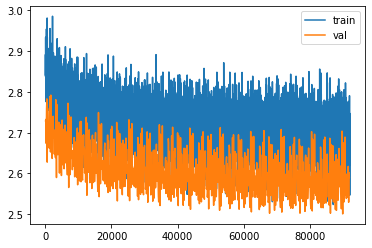

In [47]:
plot_loss(train_loss, val_loss)

In [49]:
generate_batch(model, 20)

['хадорбым',
 'зетитеслял',
 'треждил',
 'зытавачивасе',
 'снежешь',
 'жуломнержссом',
 'дреар',
 'вьенрее',
 'очердом',
 'нокакоское',
 'илило-тложимом',
 'числалесхих',
 'зелаликох',
 'вгогосьсь',
 'ёбный',
 'пре',
 'сеслокую',
 'тысрыс',
 'мылкийся',
 'вогнетавив']